<a href="https://colab.research.google.com/github/jobas5/fp_data_mining/blob/main/data_mining_disaster_tweets_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Downloading Dataset

In [1]:
data_train = !gdown -- 173LxuZawUWO-h6nVRsV5qaXiwmIN-vcB
data_test = !gdown -- 1P-UkhwPMhNyHzgJbT_SmBzc0Z4Tcmbgc

# Import Packages and Load Dataset

In [2]:
import re
import string
import shutil
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, GlobalMaxPooling1D, Conv1D, Dropout, TextVectorization
from tensorflow.keras.losses import BinaryCrossentropy
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

In [3]:
train = pd.read_csv("/content/train.csv")
test = pd.read_csv("/content/test.csv")

# Dataset Overview

In [4]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [6]:
train.shape

(7613, 5)

In [7]:
test.shape

(3263, 4)

In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [9]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB


In [10]:
train.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [11]:
train['keyword'].fillna(train['keyword'].mode()[0], inplace=True)

In [12]:
train.isnull().sum()

id             0
keyword        0
location    2533
text           0
target         0
dtype: int64

# Data Prepocessing and Cleansing

Regex manipulation

In [13]:
def custom_tokenize(input_data):
    lowercase = tf.strings.lower(input_data)
    stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
    stripped_hyperlink = tf.strings.regex_replace(stripped_html, 'https?://\S+|www\.\S+', '')
    stripped_square_brackets = tf.strings.regex_replace(stripped_hyperlink, '\[.*?\]', '')
    stripped_punctuation = tf.strings.regex_replace(stripped_square_brackets, '[%s]' % re.escape(string.punctuation), '')
    stripped_punctuation = tf.strings.regex_replace(stripped_punctuation, '\n', '')
    stripped_number = tf.strings.regex_replace(stripped_punctuation, '\w*\d\w*', '')
    
    return tf.strings.regex_replace(stripped_number, '[%s]' % re.escape(string.punctuation), '')

In [14]:
train['text'] = custom_tokenize(train['text'])

In [15]:
train['text']

0       b'our deeds are the reason of this earthquake ...
1                b'forest fire near la ronge sask canada'
2       b'all residents asked to shelter in place are ...
3       b' people receive wildfires evacuation orders ...
4       b'just got sent this photo from ruby alaska as...
                              ...                        
7608    b'two giant cranes holding a bridge collapse i...
7609    b'ariaahrary thetawniest the out of control wi...
7610                            b'  s of volcano hawaii '
7611    b'police investigating after an ebike collided...
7612    b'the latest more homes razed by northern cali...
Name: text, Length: 7613, dtype: object

Text Vectorization

In [16]:
#hyperParam
max_features = 1000
sequence_length = 75

In [17]:
vectorize_layer = TextVectorization(
                    standardize = custom_tokenize,
                    max_tokens = max_features,
                    output_mode = 'int',
                    output_sequence_length=sequence_length)

In [18]:
train['text'].values

array([b'our deeds are the reason of this earthquake may allah forgive us all',
       b'forest fire near la ronge sask canada',
       b'all residents asked to shelter in place are being notified by officers no other evacuation or shelter in place orders are expected',
       ..., b'  s of volcano hawaii ',
       b'police investigating after an ebike collided with a car in little portugal ebike rider suffered serious nonlife threatening injuries',
       b'the latest more homes razed by northern california wildfire  abc news '],
      dtype=object)

In [19]:
vectorize_layer.adapt(train['text'].values)

In [20]:
vectorize_text = vectorize_layer(train['text'].values)
vectorize_text

<tf.Tensor: shape=(7613, 75), dtype=int64, numpy=
array([[108,   1,  22, ...,   0,   0,   0],
       [176,  44, 210, ...,   0,   0,   0],
       [ 40,   1,   1, ...,   0,   0,   0],
       ...,
       [209,   6, 540, ...,   0,   0,   0],
       [ 76,   1,  38, ...,   0,   0,   0],
       [  2, 193,  52, ...,   0,   0,   0]])>

# Define Model

In [21]:
Xs = vectorize_text
y = train['target']

In [22]:
#hyperparam
embedding_dim = 32
filters = 128
kernel_size = 5
dense_dim = 256

In [23]:
model = Sequential([
    Embedding(max_features + 1, embedding_dim),
    Conv1D(filters=filters, kernel_size=kernel_size, activation='relu'),
    GlobalMaxPooling1D(),
    Dropout(0.2),
    Dense(dense_dim, activation='relu'),
    Dense(1, activation='sigmoid')
])

In [24]:
model.compile(loss='binary_crossentropy', optimizer='Adamax', metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          32032     
                                                                 
 conv1d (Conv1D)             (None, None, 128)         20608     
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 256)               33024     
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                        

In [26]:
NUM_EPOCHS = 15
VAL_SPLIT = 0.2

In [27]:
history = model.fit(Xs, y, epochs=NUM_EPOCHS, validation_split=VAL_SPLIT)

Epoch 1/15
191/191 [==============================] - 10s 40ms/step - loss: 0.6709 - accuracy: 0.5864 - precision: 0.7172 - recall: 0.0277 - val_loss: 0.6544 - val_accuracy: 0.6087 - val_precision: 0.7580 - val_recall: 0.2341
Epoch 2/15
191/191 [==============================] - 5s 26ms/step - loss: 0.5702 - accuracy: 0.7258 - precision: 0.7543 - recall: 0.5164 - val_loss: 0.5688 - val_accuracy: 0.7236 - val_precision: 0.7581 - val_recall: 0.5966
Epoch 3/15
191/191 [==============================] - 5s 29ms/step - loss: 0.4846 - accuracy: 0.7765 - precision: 0.7756 - recall: 0.6596 - val_loss: 0.5392 - val_accuracy: 0.7387 - val_precision: 0.8193 - val_recall: 0.5628
Epoch 4/15
191/191 [==============================] - 5s 27ms/step - loss: 0.4335 - accuracy: 0.8074 - precision: 0.8135 - recall: 0.7034 - val_loss: 0.4951 - val_accuracy: 0.7702 - val_precision: 0.7947 - val_recall: 0.6827
Epoch 5/15
191/191 [==============================] - 3s 15ms/step - loss: 0.3965 - accuracy: 0.824

In [28]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'precision', 'recall', 'val_loss', 'val_accuracy', 'val_precision', 'val_recall'])

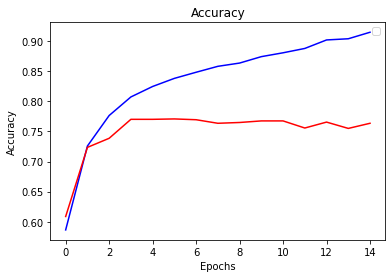

In [29]:
plt.plot(history.history['accuracy'], color='b')
plt.plot(history.history['val_accuracy'], color='r')

plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend('Training', 'Validation')

plt.show()

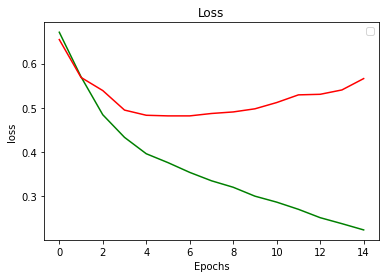

In [30]:
plt.plot(history.history['loss'], color='g')
plt.plot(history.history['val_loss'], color='r')

plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend('Training', 'Validation')

plt.show()

# Test Model

In [31]:
test['text'] = custom_tokenize(test['text'])

In [32]:
import random

random_num = random.randint(0, (3263-1))

data = test['text'][random_num]

input_data = vectorize_layer(data)

predictions = model.predict(np.expand_dims(input_data, 0))

print(data)
print(predictions)

b'residents set up sign as tribute to families who lost their lives in the thane building collapse the unfortun  '
[[0.96251273]]


In [33]:
value = predictions[0][0]
value > 0.5

True

In [34]:
if value>0.5 or value == 0.5:
    print('Disaster Tweets')
elif value < 0.5:
    print('Not a Disaster Tweets')

Disaster Tweets


# Submitting

In [35]:
submission = !gdown -- 10O8-jdDN_Y07C5IJ93yhG762FLiklpOf

In [36]:
submit_data = test['text']
input_submit = vectorize_layer(submit_data)
prediksi = model.predict(input_submit)

In [37]:
prediksi_target = []
for pred in prediksi:
    if pred >= 0.5:
        prediksi_target.append(1)
    else:
        prediksi_target.append(0)

In [38]:
submission = pd.DataFrame({'id':test['id'].values.tolist(), 'target':prediksi_target})

In [39]:
submission.to_csv('submission.csv', index=False)